# Creating training data

In [7]:
import numpy as np
%matplotlib inline
import matplotlib.pylab as plt
import os

from pyiron import Project

Start a project

In [2]:
pr = Project("creating_datasets")

## Creating a structure "container" from the data

We now go over the jobs generated in the first notebook to store structures, energies, and forces into a structure container which will later be used for potential fitting

**Note**: Usually these datasets are created using highly accurate DFT calculations. But for practical reasons, we only demonstrate how to do this using data from LAMMPS calculations (the workflow remain the same)

In [4]:
pr_fs = pr["../first_steps"]

Create a TrainingContainer job (to store structures and databases).

In [4]:
container = pr.create.job.TrainingContainer('dataset_example')

## Add structures from the E-V curves

For starters, we append structures from the energy volume curves we calculated earlier

In [6]:
for job in pr_fs["E_V_curve"].iter_jobs(status="finished"):
    container.include_job(job)

  0%|          | 0/7 [00:00<?, ?it/s]

We can obtain this data as a `pandas` table

In [7]:
container.to_pandas()

name  \
0  job_a_3_8   
1  job_a_3_9   
2  job_a_4_0   
3  job_a_4_1   
4  job_a_4_2   
5  job_a_4_3   
6  job_a_4_4   

                                                                                                                                                                                                     atoms  \
0  [element: [None, AtomicNumber                       13\nAtomicRadius                    118.0\nAtomicMass                  26.981539\nColor                          Silver\nCovalentRadius         ...   
1  [element: [None, AtomicNumber                       13\nAtomicRadius                    118.0\nAtomicMass                  26.981539\nColor                          Silver\nCovalentRadius         ...   
2  [element: [None, AtomicNumber                       13\nAtomicRadius                    118.0\nAtomicMass                  26.981539\nColor                          Silver\nCovalentRadius         ...   
3  [element: [None, AtomicNumber                       13\nAtomicRadius                    118.0\nAtomicMass                  26.981539\nColor                          Silver\nCovalentRadius         ...   
4  [element: [None, AtomicNumber                       13\nAtomicRadius                    118.0\nAtomicMass                  26.981539\nColor                          Silver\nCovalentRadius         ...   
5  [element: [None, AtomicNumber                       13\nAtomicRadius                    118.0\nAtomicMass                  26.981539\nColor                          Silver\nCovalentRadius         ...   
6  [element: [None, AtomicNumber                       13\nAtomicRadius                    118.0\nAtomicMass                  26.981539\nColor                          Silver\nCovalentRadius         ...   

     energy  \
0 -3.192897   
1 -3.319542   
2 -3.367063   
3 -3.360600   
4 -3.317017   
5 -3.241535   
6 -3.145751   

                                                                        forces  \
0   [[1.6276043110675176e-16, 1.0529105848988851e-16, 5.1718187378489473e-17]]   
1     [[7.639186604470375e-18, 1.2897999183801789e-17, 6.560662375038692e-17]]   
2   [[-3.5024524628727396e-17, -1.320930466294525e-17, 5.849496262865057e-18]]   
3  [[-2.237762269513316e-17, -4.0689075283847526e-17, 2.1062919550300275e-17]]   
4    [[2.140556230444804e-17, 9.465137265930533e-17, -1.6146749725116617e-17]]   
5  [[-5.0018187940959333e-17, -7.753256254350387e-17, -7.947668332487412e-17]]   
6    [[-7.31320096256601e-17, 2.773206044106321e-16, -1.2031135854225408e-16]]   

                                                                                                                                   stress  \
0      [25.037460606087844, 25.03746060546885, 25.03746060312137, 1.2058153515681625e-10, -5.4886913858354095e-11, 5.489273462444544e-11]   
1     [11.783580963401858, 11.783580963641624, 11.783580962525912, -9.081682946998626e-10, -5.281239282339811e-10, 5.281079211272299e-10]   
2       [2.177486595771194, 2.1774865945028847, 2.1774865945028834, -1.07506321000983e-09, 1.2040691217407586e-09, 7.657961759832688e-10]   
3  [-3.3265634524504444, -3.3265634530820014, -3.3265634530820085, -6.528356607304887e-10, 1.6521880752407014e-12, 6.566095180460252e-10]   
4       [-7.344005402848352, -7.344005402593722, -7.344005404806233, -4.6368149924092e-10, -7.669372280361131e-10, 7.669350452488288e-10]   
5     [-10.206225126673713, -10.206225127480902, -10.2062251274809, -6.120026228018106e-11, 5.826092092320323e-10, 7.850612746551634e-11]   
6   [-11.04382992252993, -11.043829922467113, -11.043829922415048, -1.632215571589768e-11, 6.058689905330539e-12, -6.060145096853376e-12]   

   number_of_atoms  
0                1  
1                1  
2                1  
3                1  
4                1  
5                1  
6                1

## Add structures from the MD

We also add some structures obtained from the MD simulations

Reloading the MD job.  Indexing a project loads jobs within.

In [8]:
job_md = pr_fs["lammps_job"]

We can now iterate over the structures within and add each of them to the container.

In [9]:
traj_length = job_md.number_of_structures
stride = 10

By default include_job will fetch the last computation step from the given job
for other steps you have to explicitly pass which step you want.

In [10]:
for i in range(0, traj_length, stride):
    container.include_job(job_md, iteration_step=i)

## Add some defect structures (vacancies, surfaces, etc)

It's necessary to also include some defect structures, and surfaces to the training dataset.

Setup a MD calculation for a structure with a vacancy.

In [11]:
job_lammps = pr.create.job.Lammps("lammps_job_vac")
job_lammps.structure = pr.create.structure.bulk("Al", cubic=True, a=3.61).repeat([3, 3, 3])

remove the first atom of the structure to create the vacancy

In [12]:
del job_lammps.structure[0]
job_lammps.potential = "2005--Mendelev-M-I--Al-Fe--LAMMPS--ipr1"
job_lammps.calc_md(temperature=800, pressure=0, n_ionic_steps=10000)
job_lammps.run()

The job lammps_job_vac was saved and received the ID: 94


Setup a MD calculation for a surface structure

In [13]:
job_lammps = pr.create.job.Lammps("lammps_job_surf")
job_lammps.structure = pr.create.structure.surface("Al", surface_type="fcc111", size=(4, 4, 8), vacuum=12, orthogonal=True)
job_lammps.potential = "2005--Mendelev-M-I--Al-Fe--LAMMPS--ipr1"
job_lammps.calc_md(temperature=800, pressure=0, n_ionic_steps=10000)
job_lammps.run()

The job lammps_job_surf was saved and received the ID: 95


In [14]:
pr

{'groups': [], 'nodes': ['lammps_job_vac', 'lammps_job_surf']}

We now add these structures to the dataset like we did before.

In [15]:
for job_md in pr.iter_jobs(status="finished", hamilton="Lammps"):
    stride = 10
    for i in range(0, job.number_of_structures, stride):
        container.include_job(job_md, iteration_step=i)

  0%|          | 0/2 [00:00<?, ?it/s]

We run the job to store this dataset in the pyiron database.  Without running the training container "job" the data will **not** saved!

In [16]:
container.run()

The job dataset_example was saved and received the ID: 96


In [17]:
pr.job_table()

id    status chemicalformula              job            subjob  \
0  94  finished           Al107   lammps_job_vac   /lammps_job_vac   
1  95  finished           Al128  lammps_job_surf  /lammps_job_surf   
2  96  finished            None  dataset_example  /dataset_example   

     projectpath                                     project  \
0  /home/jovyan/  potentials/introduction/creating_datasets/   
1  /home/jovyan/  potentials/introduction/creating_datasets/   
2  /home/jovyan/  potentials/introduction/creating_datasets/   

                   timestart                   timestop  totalcputime  \
0 2022-06-07 16:37:46.720756 2022-06-07 16:37:49.823856           3.0   
1 2022-06-07 16:37:51.214853 2022-06-07 16:37:53.832937           2.0   
2 2022-06-07 16:37:56.081557                        NaT           NaN   

                    computer           hamilton hamversion parentid masterid  
0  pyiron@jupyter-m-2epoul#1             Lammps        0.1     None     None  
1  pyiron@jupyter-m-2epoul#1             Lammps        0.1     None     None  
2  pyiron@jupyter-m-2epoul#1  TrainingContainer        0.4     None     None

## Reloading the dataset

This dataset can now be reloaded anywhere to use in the potential fitting procedures

In [18]:
dataset = pr["dataset_example"]
dataset.to_pandas()

name  \
0         job_a_3_8   
1         job_a_3_9   
2         job_a_4_0   
3         job_a_4_1   
4         job_a_4_2   
5         job_a_4_3   
6         job_a_4_4   
7        lammps_job   
8        lammps_job   
9        lammps_job   
10       lammps_job   
11       lammps_job   
12       lammps_job   
13       lammps_job   
14       lammps_job   
15       lammps_job   
16       lammps_job   
17       lammps_job   
18   lammps_job_vac   
19  lammps_job_surf   

                                                                                                                                                                                                      atoms  \
0   [element: [None, AtomicNumber                       13\nAtomicRadius                    118.0\nAtomicMass                  26.981539\nColor                          Silver\nCovalentRadius         ...   
1   [element: [None, AtomicNumber                       13\nAtomicRadius                    118.0\nAtomicMass                  26.981539\nColor                          Silver\nCovalentRadius         ...   
2   [element: [None, AtomicNumber                       13\nAtomicRadius                    118.0\nAtomicMass                  26.981539\nColor                          Silver\nCovalentRadius         ...   
3   [element: [None, AtomicNumber                       13\nAtomicRadius                    118.0\nAtomicMass                  26.981539\nColor                          Silver\nCovalentRadius         ...   
4   [element: [None, AtomicNumber                       13\nAtomicRadius                    118.0\nAtomicMass                  26.981539\nColor                          Silver\nCovalentRadius         ...   
5   [element: [None, AtomicNumber                       13\nAtomicRadius                    118.0\nAtomicMass                  26.981539\nColor                          Silver\nCovalentRadius         ...   
6   [element: [None, AtomicNumber                       13\nAtomicRadius                    118.0\nAtomicMass                  26.981539\nColor                          Silver\nCovalentRadius         ...   
7   [element: [None, AtomicNumber                       13\nAtomicRadius                    118.0\nAtomicMass                  26.981539\nColor                          Silver\nCovalentRadius         ...   
8   [element: [None, AtomicNumber                       13\nAtomicRadius                    118.0\nAtomicMass                  26.981539\nColor                          Silver\nCovalentRadius         ...   
9   [element: [None, AtomicNumber                       13\nAtomicRadius                    118.0\nAtomicMass                  26.981539\nColor                          Silver\nCovalentRadius         ...   
10  [element: [None, AtomicNumber                       13\nAtomicRadius                    118.0\nAtomicMass                  26.981539\nColor                          Silver\nCovalentRadius         ...   
11  [element: [None, AtomicNumber                       13\nAtomicRadius                    118.0\nAtomicMass                  26.981539\nColor                          Silver\nCovalentRadius         ...   
12  [element: [None, AtomicNumber                       13\nAtomicRadius                    118.0\nAtomicMass                  26.981539\nColor                          Silver\nCovalentRadius         ...   
13  [element: [None, AtomicNumber                       13\nAtomicRadius                    118.0\nAtomicMass                  26.981539\nColor                          Silver\nCovalentRadius         ...   
14  [element: [None, AtomicNumber                       13\nAtomicRadius                    118.0\nAtomicMass                  26.981539\nColor                          Silver\nCovalentRadius         ...   
15  [element: [None, AtomicNumber                       13\nAtomicRadius                    118.0\nAtomicMass                  26.981539\nColor                          Silver\nCovalentRadius         ...   
16  [element

We can now inspect the data in this dataset quite easily

In [19]:
struct = dataset.get_structure(10)

In [20]:
struct.plot3d()

NGLWidget()

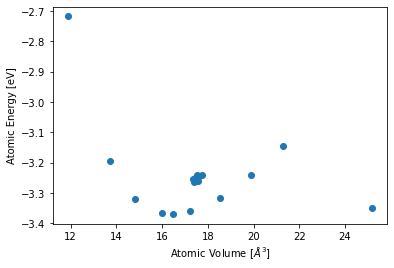

In [21]:
dataset.plot.energy_volume();

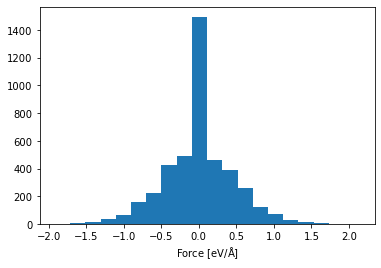

In [22]:
dataset.plot.forces()